In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import pickle as pkl

tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
### Abbreviatiuons
# dis_*: discriminator network
# gen_*: generator network

########################
### Helper functions
########################

def leaky_relu(x, alpha=0.0001):
    return tf.maximum(alpha * x, x)


########################
### DATASET
########################

mnist = input_data.read_data_sets('./dataset/MNIST_data')


#########################
### SETTINGS
#########################

# Hyperparameters
learning_rate = 0.0001
training_epochs = 200
batch_size = 64
dropout_rate = 0.5

# Architecture
dis_input_size = 784
gen_input_size = 100

# Other settings
print_interval = 200

#########################
### GRAPH DEFINITION
#########################

g = tf.Graph()
with g.as_default():
    
    # Placeholders for settings
    dropout = tf.placeholder(tf.float32, shape=None, name='dropout')
    is_training = tf.placeholder(tf.bool, shape=None, name='is_training')
    
    # Input data
    dis_x = tf.placeholder(tf.float32, shape=[None, dis_input_size],
                           name='discriminator_inputs')     
    gen_x = tf.placeholder(tf.float32, [None, gen_input_size],
                           name='generator_inputs')


    ##################
    # Generator Model
    ##################

    with tf.variable_scope('generator'):
        
        # 100 => 784 => 7x7x64
        gen_fc = tf.layers.dense(inputs=gen_x, units=3136,
                                 bias_initializer=None, # no bias required when using batch_norm
                                 activation=None)
        gen_fc = tf.layers.batch_normalization(gen_fc, training=is_training)
        gen_fc = leaky_relu(gen_fc)
        gen_fc = tf.reshape(gen_fc, (-1, 7, 7, 64))
        
        # 7x7x64 => 14x14x32
        deconv1 = tf.layers.conv2d_transpose(gen_fc, filters=32, 
                                             kernel_size=(3, 3), strides=(2, 2), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv1 = tf.layers.batch_normalization(deconv1, training=is_training)
        deconv1 = leaky_relu(deconv1)     
        deconv1 = tf.layers.dropout(deconv1, rate=dropout_rate)
        
        # 14x14x32 => 28x28x16
        deconv2 = tf.layers.conv2d_transpose(deconv1, filters=16, 
                                             kernel_size=(3, 3), strides=(2, 2), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv2 = tf.layers.batch_normalization(deconv2, training=is_training)
        deconv2 = leaky_relu(deconv2)     
        deconv2 = tf.layers.dropout(deconv2, rate=dropout_rate)
        
        # 28x28x16 => 28x28x8
        deconv3 = tf.layers.conv2d_transpose(deconv2, filters=8, 
                                             kernel_size=(3, 3), strides=(1, 1), 
                                             padding='same',
                                             bias_initializer=None,
                                             activation=None)
        deconv3 = tf.layers.batch_normalization(deconv3, training=is_training)
        deconv3 = leaky_relu(deconv3)     
        deconv3 = tf.layers.dropout(deconv3, rate=dropout_rate)
        
        # 28x28x8 => 28x28x1
        gen_logits = tf.layers.conv2d_transpose(deconv3, filters=1, 
                                                kernel_size=(3, 3), strides=(1, 1), 
                                                padding='same',
                                                bias_initializer=None,
                                                activation=None)
        gen_out = tf.tanh(gen_logits, 'generator_outputs')


    ######################
    # Discriminator Model
    ######################
    
    def build_discriminator_graph(input_x, reuse=None):

        with tf.variable_scope('discriminator', reuse=reuse):
            
            # 28x28x1 => 14x14x8
            conv_input = tf.reshape(input_x, (-1, 28, 28, 1))
            conv1 = tf.layers.conv2d(conv_input, filters=8, kernel_size=(3, 3),
                                     strides=(2, 2), padding='same',
                                     bias_initializer=None,
                                     activation=None)
            conv1 = tf.layers.batch_normalization(conv1, training=is_training)
            conv1 = leaky_relu(conv1)
            conv1 = tf.layers.dropout(conv1, rate=dropout_rate)
            
            # 14x14x8 => 7x7x32
            conv2 = tf.layers.conv2d(conv1, filters=32, kernel_size=(3, 3),
                                     strides=(2, 2), padding='same',
                                     bias_initializer=None,
                                     activation=None)
            conv2 = tf.layers.batch_normalization(conv2, training=is_training)
            conv2 = leaky_relu(conv2)
            conv2 = tf.layers.dropout(conv2, rate=dropout_rate)

            # fully connected layer
            fc_input = tf.reshape(conv2, (-1, 7*7*32))
            logits = tf.layers.dense(inputs=fc_input, units=1, activation=None)
            out = tf.sigmoid(logits)
            
        return logits, out    

    # Create a discriminator for real data and a discriminator for fake data
    dis_real_logits, dis_real_out = build_discriminator_graph(dis_x, reuse=False)
    dis_fake_logits, dis_fake_out = build_discriminator_graph(gen_out, reuse=True)


    #####################################
    # Generator and Discriminator Losses
    #####################################
    
    # Two discriminator cost components: loss on real data + loss on fake data
    # Real data has class label 0, fake data has class label 1
    dis_real_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real_logits, 
                                                            labels=tf.zeros_like(dis_real_logits))
    dis_fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits, 
                                                            labels=tf.ones_like(dis_fake_logits))
    dis_cost = tf.add(tf.reduce_mean(dis_fake_loss), 
                      tf.reduce_mean(dis_real_loss), 
                      name='discriminator_cost')
 
    # Generator cost: difference between dis. prediction and label "0" for real images
    gen_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake_logits,
                                                       labels=tf.zeros_like(dis_fake_logits))
    gen_cost = tf.reduce_mean(gen_loss, name='generator_cost')
    
    
    #########################################
    # Generator and Discriminator Optimizers
    #########################################
      
    dis_optimizer = tf.train.AdamOptimizer(learning_rate)
    dis_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='discriminator')
    dis_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')
    
    with tf.control_dependencies(dis_update_ops): # required to upd. batch_norm params
        dis_train = dis_optimizer.minimize(dis_cost, var_list=dis_train_vars,
                                           name='train_discriminator')
    
    gen_optimizer = tf.train.AdamOptimizer(learning_rate)
    gen_train_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='generator')
    gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
    
    with tf.control_dependencies(gen_update_ops): # required to upd. batch_norm params
        gen_train = gen_optimizer.minimize(gen_cost, var_list=gen_train_vars,
                                           name='train_generator')
    
    # Saver to save session for reuse
    saver = tf.train.Saver()

W0628 04:46:33.286369 139655104055104 deprecation.py:323] From <ipython-input-2-31def1cf6b17>:17: read_data_sets (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0628 04:46:33.287293 139655104055104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:260: maybe_download (from tensorflow.contrib.learn.python.learn.datasets.base) is deprecated and will be removed in a future version.
Instructions for updating:
Please write your own downloading logic.
W0628 04:46:33.287825 139655104055104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:262: extract_images (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructio

Extracting ./dataset/MNIST_data/train-images-idx3-ubyte.gz
Extracting ./dataset/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./dataset/MNIST_data/t10k-images-idx3-ubyte.gz


W0628 04:46:33.508905 139655104055104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/contrib/learn/python/learn/datasets/mnist.py:290: DataSet.__init__ (from tensorflow.contrib.learn.python.learn.datasets.mnist) is deprecated and will be removed in a future version.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
W0628 04:46:33.655077 139655104055104 deprecation.py:323] From <ipython-input-2-31def1cf6b17>:64: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0628 04:46:33.659044 139655104055104 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the 

Extracting ./dataset/MNIST_data/t10k-labels-idx1-ubyte.gz


W0628 04:46:34.016828 139655104055104 deprecation.py:323] From <ipython-input-2-31def1cf6b17>:65: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0628 04:46:34.116640 139655104055104 deprecation.py:323] From <ipython-input-2-31def1cf6b17>:74: conv2d_transpose (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
W0628 04:46:34.692932 139655104055104 deprecation.py:323] From <ipython-input-2-31def1cf6b17>:77: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.
W0628 0

In [3]:
##########################
### TRAINING & EVALUATION
##########################
import time 
start_time = time.time()

with tf.Session(graph=g) as sess:
    sess.run(tf.global_variables_initializer())
    
    avg_costs = {'discriminator': [], 'generator': []}

    for epoch in range(training_epochs):
        dis_avg_cost, gen_avg_cost = 0., 0.
        total_batch = mnist.train.num_examples // batch_size

        for i in range(total_batch):
            
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            batch_x = batch_x*2 - 1 # normalize
            batch_randsample = np.random.uniform(-1, 1, size=(batch_size, gen_input_size))
            
            # Train
            
            _, dc = sess.run(['train_discriminator', 'discriminator_cost:0'],
                             feed_dict={'discriminator_inputs:0': batch_x, 
                                        'generator_inputs:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            _, gc = sess.run(['train_generator', 'generator_cost:0'],
                             feed_dict={'generator_inputs:0': batch_randsample,
                                        'dropout:0': dropout_rate,
                                        'is_training:0': True})
            
            dis_avg_cost += dc
            gen_avg_cost += gc

            if not i % print_interval:
                print("Minibatch: %04d | Dis/Gen Cost:    %.3f/%.3f" % (i + 1, dc, gc))
                

        print("Epoch:     %04d | Dis/Gen AvgCost: %.3f/%.3f" % 
              (epoch + 1, dis_avg_cost / total_batch, gen_avg_cost / total_batch))
        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
        
        avg_costs['discriminator'].append(dis_avg_cost / total_batch)
        avg_costs['generator'].append(gen_avg_cost / total_batch)
    
    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    saver.save(sess, save_path='./model/gan-conv.ckpt')

Minibatch: 0001 | Dis/Gen Cost:    1.344/0.799
Minibatch: 0201 | Dis/Gen Cost:    0.387/1.934
Minibatch: 0401 | Dis/Gen Cost:    0.147/2.712
Minibatch: 0601 | Dis/Gen Cost:    0.408/2.030
Minibatch: 0801 | Dis/Gen Cost:    0.870/1.344
Epoch:     0001 | Dis/Gen AvgCost: 0.448/1.963
Time elapsed: 0.16 min
Minibatch: 0001 | Dis/Gen Cost:    0.792/1.451
Minibatch: 0201 | Dis/Gen Cost:    0.897/1.143
Minibatch: 0401 | Dis/Gen Cost:    0.955/1.200
Minibatch: 0601 | Dis/Gen Cost:    0.732/1.276
Minibatch: 0801 | Dis/Gen Cost:    0.854/1.227
Epoch:     0002 | Dis/Gen AvgCost: 0.876/1.203
Time elapsed: 0.29 min
Minibatch: 0001 | Dis/Gen Cost:    1.003/1.227
Minibatch: 0201 | Dis/Gen Cost:    0.983/1.136
Minibatch: 0401 | Dis/Gen Cost:    0.854/1.161
Minibatch: 0601 | Dis/Gen Cost:    0.791/1.161
Minibatch: 0801 | Dis/Gen Cost:    0.835/1.089
Epoch:     0003 | Dis/Gen AvgCost: 0.869/1.189
Time elapsed: 0.41 min
Minibatch: 0001 | Dis/Gen Cost:    0.799/1.273
Minibatch: 0201 | Dis/Gen Cost:    0.8

Minibatch: 0201 | Dis/Gen Cost:    1.359/0.790
Minibatch: 0401 | Dis/Gen Cost:    1.311/0.785
Minibatch: 0601 | Dis/Gen Cost:    1.263/0.884
Minibatch: 0801 | Dis/Gen Cost:    1.324/0.747
Epoch:     0028 | Dis/Gen AvgCost: 1.319/0.804
Time elapsed: 3.50 min
Minibatch: 0001 | Dis/Gen Cost:    1.212/0.860
Minibatch: 0201 | Dis/Gen Cost:    1.262/0.790
Minibatch: 0401 | Dis/Gen Cost:    1.279/0.834
Minibatch: 0601 | Dis/Gen Cost:    1.252/0.893
Minibatch: 0801 | Dis/Gen Cost:    1.317/0.853
Epoch:     0029 | Dis/Gen AvgCost: 1.327/0.798
Time elapsed: 3.62 min
Minibatch: 0001 | Dis/Gen Cost:    1.343/0.758
Minibatch: 0201 | Dis/Gen Cost:    1.332/0.833
Minibatch: 0401 | Dis/Gen Cost:    1.405/0.791
Minibatch: 0601 | Dis/Gen Cost:    1.307/0.805
Minibatch: 0801 | Dis/Gen Cost:    1.310/0.832
Epoch:     0030 | Dis/Gen AvgCost: 1.345/0.793
Time elapsed: 3.74 min
Minibatch: 0001 | Dis/Gen Cost:    1.373/0.750
Minibatch: 0201 | Dis/Gen Cost:    1.348/0.773
Minibatch: 0401 | Dis/Gen Cost:    1.3

Minibatch: 0201 | Dis/Gen Cost:    1.433/0.667
Minibatch: 0401 | Dis/Gen Cost:    1.384/0.687
Minibatch: 0601 | Dis/Gen Cost:    1.349/0.741
Minibatch: 0801 | Dis/Gen Cost:    1.358/0.725
Epoch:     0055 | Dis/Gen AvgCost: 1.388/0.724
Time elapsed: 6.83 min
Minibatch: 0001 | Dis/Gen Cost:    1.401/0.733
Minibatch: 0201 | Dis/Gen Cost:    1.367/0.725
Minibatch: 0401 | Dis/Gen Cost:    1.310/0.708
Minibatch: 0601 | Dis/Gen Cost:    1.441/0.704
Minibatch: 0801 | Dis/Gen Cost:    1.390/0.706
Epoch:     0056 | Dis/Gen AvgCost: 1.388/0.725
Time elapsed: 6.95 min
Minibatch: 0001 | Dis/Gen Cost:    1.412/0.697
Minibatch: 0201 | Dis/Gen Cost:    1.385/0.741
Minibatch: 0401 | Dis/Gen Cost:    1.420/0.726
Minibatch: 0601 | Dis/Gen Cost:    1.425/0.722
Minibatch: 0801 | Dis/Gen Cost:    1.369/0.704
Epoch:     0057 | Dis/Gen AvgCost: 1.383/0.726
Time elapsed: 7.07 min
Minibatch: 0001 | Dis/Gen Cost:    1.384/0.728
Minibatch: 0201 | Dis/Gen Cost:    1.340/0.746
Minibatch: 0401 | Dis/Gen Cost:    1.3

Minibatch: 0201 | Dis/Gen Cost:    1.417/0.715
Minibatch: 0401 | Dis/Gen Cost:    1.478/0.634
Minibatch: 0601 | Dis/Gen Cost:    1.465/0.683
Minibatch: 0801 | Dis/Gen Cost:    1.396/0.724
Epoch:     0082 | Dis/Gen AvgCost: 1.390/0.708
Time elapsed: 10.17 min
Minibatch: 0001 | Dis/Gen Cost:    1.369/0.697
Minibatch: 0201 | Dis/Gen Cost:    1.433/0.708
Minibatch: 0401 | Dis/Gen Cost:    1.381/0.719
Minibatch: 0601 | Dis/Gen Cost:    1.368/0.697
Minibatch: 0801 | Dis/Gen Cost:    1.424/0.699
Epoch:     0083 | Dis/Gen AvgCost: 1.389/0.707
Time elapsed: 10.29 min
Minibatch: 0001 | Dis/Gen Cost:    1.371/0.713
Minibatch: 0201 | Dis/Gen Cost:    1.427/0.681
Minibatch: 0401 | Dis/Gen Cost:    1.415/0.718
Minibatch: 0601 | Dis/Gen Cost:    1.419/0.694
Minibatch: 0801 | Dis/Gen Cost:    1.398/0.696
Epoch:     0084 | Dis/Gen AvgCost: 1.388/0.708
Time elapsed: 10.41 min
Minibatch: 0001 | Dis/Gen Cost:    1.406/0.707
Minibatch: 0201 | Dis/Gen Cost:    1.340/0.745
Minibatch: 0401 | Dis/Gen Cost:    

Minibatch: 0201 | Dis/Gen Cost:    1.422/0.681
Minibatch: 0401 | Dis/Gen Cost:    1.367/0.707
Minibatch: 0601 | Dis/Gen Cost:    1.371/0.732
Minibatch: 0801 | Dis/Gen Cost:    1.396/0.701
Epoch:     0109 | Dis/Gen AvgCost: 1.389/0.704
Time elapsed: 13.51 min
Minibatch: 0001 | Dis/Gen Cost:    1.365/0.680
Minibatch: 0201 | Dis/Gen Cost:    1.368/0.708
Minibatch: 0401 | Dis/Gen Cost:    1.395/0.705
Minibatch: 0601 | Dis/Gen Cost:    1.391/0.683
Minibatch: 0801 | Dis/Gen Cost:    1.379/0.714
Epoch:     0110 | Dis/Gen AvgCost: 1.389/0.704
Time elapsed: 13.63 min
Minibatch: 0001 | Dis/Gen Cost:    1.373/0.694
Minibatch: 0201 | Dis/Gen Cost:    1.425/0.688
Minibatch: 0401 | Dis/Gen Cost:    1.362/0.712
Minibatch: 0601 | Dis/Gen Cost:    1.401/0.705
Minibatch: 0801 | Dis/Gen Cost:    1.413/0.706
Epoch:     0111 | Dis/Gen AvgCost: 1.389/0.705
Time elapsed: 13.76 min
Minibatch: 0001 | Dis/Gen Cost:    1.339/0.743
Minibatch: 0201 | Dis/Gen Cost:    1.415/0.667
Minibatch: 0401 | Dis/Gen Cost:    

Minibatch: 0201 | Dis/Gen Cost:    1.375/0.704
Minibatch: 0401 | Dis/Gen Cost:    1.395/0.703
Minibatch: 0601 | Dis/Gen Cost:    1.380/0.703
Minibatch: 0801 | Dis/Gen Cost:    1.401/0.694
Epoch:     0136 | Dis/Gen AvgCost: 1.393/0.696
Time elapsed: 16.86 min
Minibatch: 0001 | Dis/Gen Cost:    1.378/0.707
Minibatch: 0201 | Dis/Gen Cost:    1.398/0.703
Minibatch: 0401 | Dis/Gen Cost:    1.372/0.702
Minibatch: 0601 | Dis/Gen Cost:    1.371/0.690
Minibatch: 0801 | Dis/Gen Cost:    1.377/0.710
Epoch:     0137 | Dis/Gen AvgCost: 1.391/0.698
Time elapsed: 16.98 min
Minibatch: 0001 | Dis/Gen Cost:    1.388/0.712
Minibatch: 0201 | Dis/Gen Cost:    1.406/0.693
Minibatch: 0401 | Dis/Gen Cost:    1.385/0.699
Minibatch: 0601 | Dis/Gen Cost:    1.366/0.718
Minibatch: 0801 | Dis/Gen Cost:    1.395/0.677
Epoch:     0138 | Dis/Gen AvgCost: 1.392/0.697
Time elapsed: 17.10 min
Minibatch: 0001 | Dis/Gen Cost:    1.402/0.692
Minibatch: 0201 | Dis/Gen Cost:    1.374/0.714
Minibatch: 0401 | Dis/Gen Cost:    

Minibatch: 0201 | Dis/Gen Cost:    1.402/0.692
Minibatch: 0401 | Dis/Gen Cost:    1.360/0.710
Minibatch: 0601 | Dis/Gen Cost:    1.359/0.720
Minibatch: 0801 | Dis/Gen Cost:    1.374/0.704
Epoch:     0163 | Dis/Gen AvgCost: 1.389/0.698
Time elapsed: 20.20 min
Minibatch: 0001 | Dis/Gen Cost:    1.399/0.683
Minibatch: 0201 | Dis/Gen Cost:    1.401/0.678
Minibatch: 0401 | Dis/Gen Cost:    1.373/0.697
Minibatch: 0601 | Dis/Gen Cost:    1.407/0.680
Minibatch: 0801 | Dis/Gen Cost:    1.407/0.685
Epoch:     0164 | Dis/Gen AvgCost: 1.391/0.696
Time elapsed: 20.33 min
Minibatch: 0001 | Dis/Gen Cost:    1.403/0.696
Minibatch: 0201 | Dis/Gen Cost:    1.434/0.684
Minibatch: 0401 | Dis/Gen Cost:    1.377/0.706
Minibatch: 0601 | Dis/Gen Cost:    1.385/0.700
Minibatch: 0801 | Dis/Gen Cost:    1.371/0.695
Epoch:     0165 | Dis/Gen AvgCost: 1.388/0.698
Time elapsed: 20.45 min
Minibatch: 0001 | Dis/Gen Cost:    1.402/0.690
Minibatch: 0201 | Dis/Gen Cost:    1.366/0.704
Minibatch: 0401 | Dis/Gen Cost:    

Minibatch: 0201 | Dis/Gen Cost:    1.403/0.679
Minibatch: 0401 | Dis/Gen Cost:    1.407/0.685
Minibatch: 0601 | Dis/Gen Cost:    1.378/0.700
Minibatch: 0801 | Dis/Gen Cost:    1.392/0.693
Epoch:     0190 | Dis/Gen AvgCost: 1.391/0.695
Time elapsed: 23.55 min
Minibatch: 0001 | Dis/Gen Cost:    1.369/0.689
Minibatch: 0201 | Dis/Gen Cost:    1.371/0.704
Minibatch: 0401 | Dis/Gen Cost:    1.389/0.691
Minibatch: 0601 | Dis/Gen Cost:    1.390/0.698
Minibatch: 0801 | Dis/Gen Cost:    1.381/0.704
Epoch:     0191 | Dis/Gen AvgCost: 1.389/0.696
Time elapsed: 23.67 min
Minibatch: 0001 | Dis/Gen Cost:    1.396/0.700
Minibatch: 0201 | Dis/Gen Cost:    1.380/0.704
Minibatch: 0401 | Dis/Gen Cost:    1.373/0.707
Minibatch: 0601 | Dis/Gen Cost:    1.392/0.691
Minibatch: 0801 | Dis/Gen Cost:    1.395/0.702
Epoch:     0192 | Dis/Gen AvgCost: 1.389/0.696
Time elapsed: 23.79 min
Minibatch: 0001 | Dis/Gen Cost:    1.380/0.711
Minibatch: 0201 | Dis/Gen Cost:    1.369/0.709
Minibatch: 0401 | Dis/Gen Cost:    

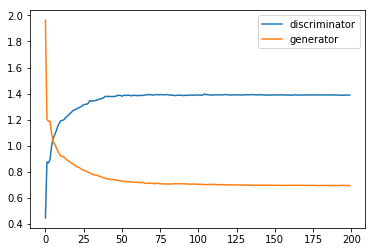

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(len(avg_costs['discriminator'])), 
         avg_costs['discriminator'], label='discriminator')
plt.plot(range(len(avg_costs['generator'])),
         avg_costs['generator'], label='generator')
plt.legend()
plt.show()

W0628 05:11:24.199790 139655104055104 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


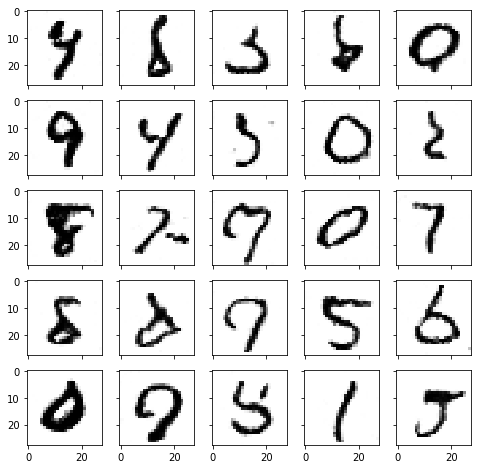

In [5]:
####################################
### RELOAD & GENERATE SAMPLE IMAGES
####################################


n_examples = 25

with tf.Session(graph=g) as sess:
    saver.restore(sess, save_path='./model/gan-conv.ckpt')

    batch_randsample = np.random.uniform(-1, 1, size=(n_examples, gen_input_size))
    new_examples = sess.run('generator/generator_outputs:0',
                            feed_dict={'generator_inputs:0': batch_randsample,
                                       'dropout:0': 0.0,
                                       'is_training:0': False})

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8, 8),
                         sharey=True, sharex=True)

for image, ax in zip(new_examples, axes.flatten()):
    ax.imshow(image.reshape((dis_input_size // 28, dis_input_size // 28)), cmap='binary')

plt.show()